In [1]:
! pip install -q evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupt

In [ ]:
from datasets import load_dataset

data = load_dataset(
    "theekshana/NER_medical_reports_tokenized_deid_roberta_i2b2",
    cache_dir="./data",
)
data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/831 [00:00<?, ?B/s]

(…)-00000-of-00001-c7d8925a08394859.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

(…)-00000-of-00001-997d6ecfa04ccd76.parquet:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [ ]:
config_labels = [
    "O",
    "B-ID",
    "I-ID",
    "B-DATE",
    "I-DATE",
    "B-LOC",
    "I-LOC",
    "B-PATIENT",
    "I-PATIENT",
    "B-AGE",
    "I-AGE",
    "B-PHONE",
    "I-PHONE",
]
label2id = {l: i for i, l in enumerate(config_labels)}
id2label = {i: l for l, i in label2id.items()}

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(
    MODEL,
    use_fast=True,
    cache_dir=f"./tokenizer/{MODEL}",
)
model = AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=len(config_labels),
    id2label=id2label,
    label2id=label2id,
    cache_dir=f"./model/{MODEL}",
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="lora_only",
    target_modules=[
        "query",
        "key",
        "value",
        "output.dense",
        "intermediate.dense",
        "attention.self.query",
        "attention.self.key",
        "attention.self.value",
        "attention.output.dense",
    ],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,747,149 || all params: 126,729,242 || trainable%: 2.1677


In [ ]:
from transformers import  DataCollatorForTokenClassification

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_offsets_mapping=True,
        is_split_into_words=False,
    )
    all_labels = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        labels = ["O"] * len(offsets)
        if "ner_tags" in examples and examples["ner_tags"][i]:
            spans = examples["ner_tags"][i]
            for span in spans:
                span_start, span_end, span_label = (
                    span["start"],
                    span["end"],
                    span["label"],
                )
                if span_label not in [
                    "ID",
                    "DATE",
                    "LOC",
                    "PATIENT",
                    "AGE",
                    "PHONE",
                ]:
                    continue

                token_indices_in_span = []
                for idx, (off_start, off_end) in enumerate(offsets):
                    if off_start == 0 and off_end == 0:
                        continue

                    token_starts_in_span = (
                        off_start >= span_start and off_start < span_end
                    )
                    token_ends_in_span = off_end > span_start and off_end <= span_end
                    token_contains_span = (
                        off_start <= span_start and off_end >= span_end
                    )

                    if (
                        token_starts_in_span
                        or token_ends_in_span
                        or token_contains_span
                    ):
                        token_indices_in_span.append(idx)

                if token_indices_in_span:
                    first_token_idx = token_indices_in_span[0]
                    labels[first_token_idx] = "B-" + span_label
                    for follow_token_idx in token_indices_in_span[1:]:
                        labels[follow_token_idx] = "I-" + span_label

        all_labels.append([label2id.get(l, label2id["O"]) for l in labels])

    tokenized["labels"] = all_labels
    if "offset_mapping" in tokenized:
        tokenized.pop("offset_mapping")
    return tokenized


tokenized_ds = data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=data["train"].column_names,
)

data_collator = DataCollatorForTokenClassification(tokenizer)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(
        predictions=true_predictions, references=true_labels, scheme="IOB2"
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="ner-medical-bert-lora-improved",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=500,
    fp16=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
pre_train_eval = trainer.evaluate(tokenized_ds["test"])
for key, value in pre_train_eval.items():
    print(f"{key}: {value:.4f}")

eval_loss: 2.6885
eval_model_preparation_time: 0.0085
eval_precision: 0.0000
eval_recall: 0.0000
eval_f1: 0.0000
eval_accuracy: 0.0017
eval_runtime: 1.6520
eval_samples_per_second: 60.5340
eval_steps_per_second: 4.2370


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Precision,Recall,F1,Accuracy
1,2.487700,1.662677,0.008500,0.000000,0.000000,0.000000,0.878594
2,0.568800,0.246932,0.008500,0.060547,0.038750,0.047256,0.919844
3,0.152200,0.039990,0.008500,0.996255,0.997500,0.996877,0.994687
4,0.019600,0.001912,0.008500,1.000000,1.000000,1.000000,1.000000
5,0.003000,0.000547,0.008500,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=315, training_loss=0.6462494570584524, metrics={'train_runtime': 86.7997, 'train_samples_per_second': 57.604, 'train_steps_per_second': 3.629, 'total_flos': 673767951360000.0, 'train_loss': 0.6462494570584524, 'epoch': 5.0})

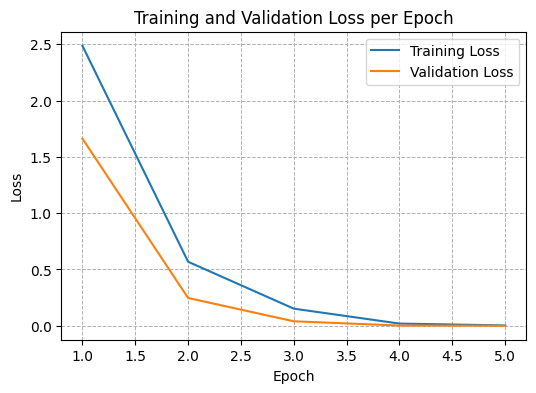

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

epochs = []
losses = []
eval_losses = []
precisions = []
recalls = []
f1s = []
accuracies = []

for entry in logs:
    if "loss" in entry and "eval_loss" not in entry:
        epochs.append(entry["epoch"])
        losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_losses.append(entry["eval_loss"])
        precisions.append(entry["eval_precision"])
        recalls.append(entry["eval_recall"])
        f1s.append(entry["eval_f1"])
        accuracies.append(entry["eval_accuracy"])

plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label="Training Loss")
plt.plot(epochs, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True, lw=0.7, linestyle="--")
plt.show()

In [ ]:
model.save_pretrained(f"results/{MODEL}-model")
tokenizer.save_pretrained(f"results/{MODEL}-tokenizer")

('results/roberta-base-tokenizer/tokenizer_config.json',
 'results/roberta-base-tokenizer/special_tokens_map.json',
 'results/roberta-base-tokenizer/vocab.json',
 'results/roberta-base-tokenizer/merges.txt',
 'results/roberta-base-tokenizer/added_tokens.json',
 'results/roberta-base-tokenizer/tokenizer.json')

In [ ]:
evaluation = trainer.evaluate(tokenized_ds["test"])
for key, value in evaluation.items():
    print(f"{key}: {value:.4f}")

eval_loss: 0.0019
eval_model_preparation_time: 0.0085
eval_precision: 1.0000
eval_recall: 1.0000
eval_f1: 1.0000
eval_accuracy: 1.0000
eval_runtime: 0.8708
eval_samples_per_second: 114.8320
eval_steps_per_second: 8.0380
epoch: 5.0000


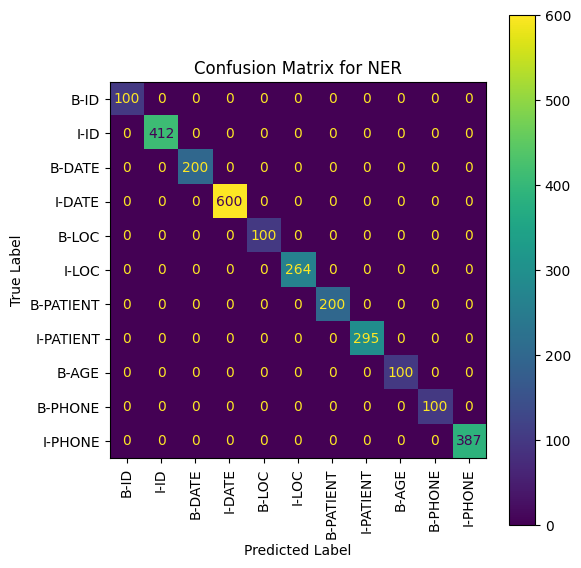

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions_output = trainer.predict(tokenized_ds["test"])
predictions = predictions_output.predictions
labels = predictions_output.label_ids
predictions = np.argmax(predictions, axis=2)

true_labels_flat = []
predicted_labels_flat = []

for i in range(len(labels)):
    for j in range(len(labels[i])):
        if labels[i][j] != -100:
            true_labels_flat.append(id2label[labels[i][j]])
            predicted_labels_flat.append(id2label[predictions[i][j]])

non_o_labels = [label for label in config_labels if label != "O"]
non_o_labels = [label for label in non_o_labels if label != "I-AGE"]

cm = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=non_o_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=non_o_labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, values_format='d')
plt.title("Confusion Matrix for NER")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_no_O.png")

In [ ]:
import torch
from collections import defaultdict

def predict_and_format(idx):
    if idx >= len(data['test']):
        print(f"Error: Index {idx} out of bounds for test set (size: {len(ds['test'])}).")
        return

    print(f"\n--- Predicting for Test Sample Index: {idx} ---")

    original_sample = data['test'][idx]
    original_text = original_sample['text']
    true_spans = original_sample['ner_tags']

    tokenized_sample = tokenized_ds['test'][idx]
    input_ids = torch.tensor([tokenized_sample['input_ids']]).to(trainer.model.device)
    attention_mask = torch.tensor([tokenized_sample['attention_mask']]).to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=2)

    predicted_label_ids = predictions[0].cpu().numpy()
    input_ids = input_ids[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    special_tokens_mask = tokenizer.get_special_tokens_mask(input_ids, already_has_special_tokens=True)

    predicted_entities = defaultdict(list)
    current_entity_tokens = []
    current_entity_label = "O"

    for i, token_id in enumerate(input_ids):
        if attention_mask[0][i] == 0 or special_tokens_mask[i] == 1:
            if current_entity_tokens:
                entity_text = tokenizer.decode(current_entity_tokens, skip_special_tokens=True)
                predicted_entities[current_entity_label].append(entity_text.strip())
                current_entity_tokens = []
                current_entity_label = "O"
            continue

        predicted_label = id2label[predicted_label_ids[i]]

        if predicted_label.startswith("B-"):
            if current_entity_tokens:
                entity_text = tokenizer.decode(current_entity_tokens, skip_special_tokens=True)
                predicted_entities[current_entity_label].append(entity_text.strip())

            current_entity_label = predicted_label[2:]
            current_entity_tokens = [token_id]
        elif predicted_label.startswith("I-"):
            label_type = predicted_label[2:]
            if label_type == current_entity_label and current_entity_tokens:
                current_entity_tokens.append(token_id)
            else:
                if current_entity_tokens:
                    entity_text = tokenizer.decode(current_entity_tokens, skip_special_tokens=True)
                    predicted_entities[current_entity_label].append(entity_text.strip())
                    current_entity_tokens = []
                    current_entity_label = "O"
        else:
            if current_entity_tokens:
                entity_text = tokenizer.decode(current_entity_tokens, skip_special_tokens=True)
                predicted_entities[current_entity_label].append(entity_text.strip())
                current_entity_tokens = []
                current_entity_label = "O"

    if current_entity_tokens:
        entity_text = tokenizer.decode(current_entity_tokens, skip_special_tokens=True)
        predicted_entities[current_entity_label].append(entity_text.strip())

    real_entities = defaultdict(list)
    for span in true_spans:
        start, end, label = span['start'], span['end'], span['label']
        if label in ["ID", "DATE", "LOC", "PATIENT", "AGE", "PHONE"]:
            real_entities[label].append(original_text[start:end])

    print("\nOriginal Text:")
    print(original_text)

    print("\n--- Predicted Entities ---")
    if not predicted_entities:
        print("No entities predicted.")
    else:
        for label, texts in predicted_entities.items():
            label_map = {"PATIENT": "Name", "AGE": "Age", "DATE": "Date", "ID": "ID", "LOC": "Location", "PHONE": "Phone"}
            print(f"{label_map.get(label, label)}: {', '.join(texts)}")

    print("\n--- Real Entities ---")
    if not real_entities:
        print("No entities in ground truth.")
    else:
        for label, texts in real_entities.items():
            label_map = {"PATIENT": "Name", "AGE": "Age", "DATE": "Date", "ID": "ID", "LOC": "Location", "PHONE": "Phone"}
            print(f"{label_map.get(label, label)}: {', '.join(texts)}")

    print("-" * (30 + len(str(idx))))

predict_and_format(i)


--- Predicting for Test Sample Index: 99 ---

Original Text:
locale: nb
noteType: clinical note
translatedNoteType: journalnotat
givenName: Samir
familyName: Wilberg
age: 74
phoneNumber: +4758127187
city: Ormåsen
healthCareUnit: Helse Bergen HF Rehabiliteringsklinikken- poliklinikk
diagnosis: M02351 Reiter's disease
birthDate: November 25. 1948
admissionDate: April 04. 2017
socialSecurityNumber: 658027 99065
findings: ['clear signs of dehydration', 'regular pulse', 'elevated core temperature', 'shallow breathing', 'high blood pressure', 'full mobility', 'moderate pain']

--- Predicted Entities ---
Name: Samir, Wilberg
Age: 74
Phone: +4758127187
Location: Ormåsen
Date: November 25. 1948, April 04. 2017
ID: 658027 99065

--- Real Entities ---
Name: Samir, Wilberg
Age: 74
Phone: +4758127187
Location: Ormåsen
Date: November 25. 1948, April 04. 2017
ID: 658027 99065
--------------------------------
